# Install libs and import them

In [1]:
import cv2                       # pip install opencv-python
import os                        # pip install os 
import pandas as pd              # pip install pandas
import numpy as np               # pip install numpy
from tqdm.notebook import tqdm  # pip install tqdm
from tqdm.notebook import trange   
import matplotlib.pyplot as plt  # pip install matplotlib
%matplotlib inline

from pathlib import Path         # pip install pathlib

from torch.utils.data import Dataset, DataLoader # pip install torch
from torchvision import transforms as tr # pip install torchvision

from re import sub               # pip install regex
import string      
from collections import Counter

import torch

from torchvision import models
from torch import nn
from IPython.display import clear_output
import warnings
from collections import OrderedDict

# Data preparation

## Label preprocessing

In [2]:
def get_labels_for_images(data_folder="/kaggle/input/image-captioning/data/data"):
    dfs = dict()
    for split in ['train', 'val']:
        dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')
    return dfs

In [3]:
def show_image(data_folder="/kaggle/input/image-captioning/data/data"):
    fig, ax = plt.subplots(figsize=(10,8))
    image = cv2.imread(os.path.join(data_folder, 'train', '0001.png')) # H x W x C
    print(type(image))
    print(image.shape)
    plt.imshow(image)
    plt.show()

def show_labels_with_image(dfs, data_folder="/kaggle/input/image-captioning/data/data"):
    inds = list(range(10))
    split = 'train'
    h, w = 2, 5
    title_width = 43
    assert h*w >= len(inds)

    fig, ax = plt.subplots(h, w, figsize=(20, 15))
    for i, ind in enumerate(inds):
        row = dfs[split].iloc[ind]
        img_id = row['img_id']
        captions = [row[f'caption #{i}'] for i in range(5)]
        caption_adjasted = map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions))
        caption = '\n'.join(caption_adjasted)
        plt.subplot(h, w, i+1)
        plt.title(caption)
        plt.imshow(cv2.imread(os.path.join(data_folder, split, img_id)))
    fig.tight_layout()
    plt.show()
    

## Image preprocessing

### Get mean and std on images for normalizing

In [4]:
def get_channel_mean_and_std(image_path=None):
    if image_path is None:
        channel_mean = np.asarray([0.40322752, 0.44634529, 0.45802264])
        channel_std = np.asarray([0.40393032, 0.38417048, 0.39457663])
        return channel_mean, channel_std
    else:
        mean = np.array([0.,0.,0.])
        files = list(Path(image_path).rglob('*.png'))
        num_samples = len(files)

        for i in range(num_samples):
            image = cv2.imread(str(files[i]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(float) / 255.
            for j in range(3):
                mean[j] += np.mean(image[:,:,j])
        mean = (mean / num_samples)
        
        std_temp = np.array([0.,0.,0.])
        std = np.array([0.,0.,0.])
        for i in range(num_samples):
            image = cv2.imread(str(files[i]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(float) / 255.
            for j in range(3):
                std_temp[j] += ((image[:,:,j] - mean[j])**2).sum() / (image.shape[0] * image.shape[1])
        std = np.sqrt(std_temp/num_samples)
        return mean, std

### Transformation

In [5]:
def get_trasnforms(channel_mean, channel_std):
    image_prepare_train = tr.Compose([
    tr.ToPILImage(),
    tr.RandomHorizontalFlip(0.5),
    tr.RandomAutocontrast(),
    tr.RandomApply([tr.GaussianBlur(5, (0.001, 5))], p=0.3),
    tr.RandomRotation(degrees=(0, 20)),
    tr.Resize([256], tr.InterpolationMode.BILINEAR),
    tr.CenterCrop([224]),
    tr.ToTensor(),
    tr.Normalize(channel_mean, channel_std)])

    image_prepare_validation = tr.Compose([
        tr.ToTensor(),
        tr.Resize([256], tr.InterpolationMode.BILINEAR),
        tr.CenterCrop([224]),
        tr.Normalize(channel_mean, channel_std)])
    return image_prepare_train, image_prepare_validation

In [6]:
def de_normalize(image, channel_mean, channel_std):
    return np.clip(image * channel_std + channel_mean, 0, 1)

In [7]:
def show_tranform_image(image, image_prepare_train, channel_mean, channel_std):
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        transformed_image = image_prepare_train(image).numpy().transpose(1, 2, 0)
        plt.imshow(de_normalize(transformed_image, channel_mean, channel_std))
    plt.show()

### Header preprocessing

In [8]:
def tokenize(text):
    return ["<BOS>"] + sub(" +", " ", sub(f"[{string.punctuation}]", ' ', text.lower())).strip().split(" ") + ["<EOS>"]

In [9]:
def get_tokens_freq_and_max_seq_len(dfs, border_to_remove=3):
    vocab_freq = Counter()
    sizes = Counter()
    for i in trange(len(dfs['train'])):
        for text in dfs['train'].iloc[i, 1:]:
            tokens = tokenize(text)
            vocab_freq.update(tokens)
            sizes.update([len(tokens)])

    unknown_count = 0
    vocab_freq = dict(vocab_freq)
    for token, count in dict(vocab_freq).items():
        if count <= border_to_remove:
            unknown_count += count
            vocab_freq.pop(token)
    vocab_freq["<UNK>"] = unknown_count
    max_seq_len = np.max(list(sizes.keys()))
    return vocab_freq, sizes, max_seq_len
    
def show_tokens_freq(vocab_freq, sizes):
    show_ = 20
    fig, ax = plt.subplots(3, 1, figsize=(20, 12))

    plt.subplot(312)
    vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
    plt.title('least popular words')
    plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

    plt.subplot(311)
    vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
    plt.title('most popular words')
    plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

    plt.subplot(313)
    plt.title('sequence sizes')
    plt.bar(list(sizes.keys()), list(sizes.values()))

    fig.tight_layout()
    plt.show()

In [10]:
def get_default_connection_between_tok_and_ind():
    tok_to_ind = {
        '<UNK>': 0,
        '<BOS>': 1,
        '<EOS>': 2,
        '<PAD>': 3,
    }
    ind_to_tok = {
        0: '<UNK>',
        1: '<BOS>',
        2: '<EOS>',
        3: '<PAD>',
    }
    return tok_to_ind, ind_to_tok

def add_default_tokens(vocab_freq, tok_to_ind=None, ind_to_tok=None):
    vocab_tokens = list(vocab_freq.keys())
    vocab_tokens.remove('<BOS>')
    vocab_tokens.remove('<EOS>')
    vocab_tokens.remove('<UNK>')
    
    if tok_to_ind is None and ind_to_tok is None: 
        tok_to_ind, ind_to_tok = get_default_connection_between_tok_and_ind()
    
    cur_len_to_add = len(tok_to_ind)
    tok_to_ind.update({tok: ind + cur_len_to_add for ind, tok in enumerate(vocab_tokens)})
    ind_to_tok = {ind: token for token, ind in tok_to_ind.items()}
    assert len(tok_to_ind) == len(ind_to_tok)
    return tok_to_ind, ind_to_tok


In [11]:
dfs = get_labels_for_images()
vocab_freq, sizes, max_seq_len = get_tokens_freq_and_max_seq_len(dfs)
tok_to_ind, ind_to_tok = add_default_tokens(vocab_freq)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [12]:
def get_ind_by_tok(token, tok_to_ind=tok_to_ind):
    if token in tok_to_ind:
        return tok_to_ind[token]
    else:
        return 0

def to_ids(text, tok_to_ind):
    tokens = tokenize(text)
    indices = [get_ind_by_tok(token, tok_to_ind) for token in tokens]
    m = {}
    for i in range(len(indices)):
        m[indices[i]] = tokens[i]
    return list(m)

def check_tokenizer_operation(text, tok_to_ind, need_print=False):
    toks = tokenize(text)
    ids = to_ids(text, tok_to_ind)
    if need_print:
        print(toks)
        print(ids)
    assert toks[0] == '<BOS>' and toks[-1] == '<EOS>'
    assert ids[0] == tok_to_ind['<BOS>'] and ids[-1] == tok_to_ind['<EOS>']

### Dataset

In [13]:
def get_global_constant_helpers(tok_to_ind):
    pad_ind = get_ind_by_tok('<PAD>', tok_to_ind)
    bos_ind = get_ind_by_tok('<BOS>', tok_to_ind)
    eos_ind = get_ind_by_tok('<EOS>', tok_to_ind)
    return pad_ind, bos_ind, eos_ind
pad_ind, bos_ind, eos_ind = get_global_constant_helpers(tok_to_ind)

class ImageCaptioningDataset(Dataset):
    """
        imgs_path ~ путь к папке с изображениями
        captions_path ~ путь к .tsv файлу с заголовками изображений
    """
    def __init__(self, imgs_path, captions_path, transformer, online_image = False):
        super(ImageCaptioningDataset).__init__()
        # Читаем и записываем из файлов в память класса, чтобы быстро обращаться внутри датасета
        # Если не хватает памяти на хранение всех изображений, то подгружайте прямо во время __getitem__, но это замедлит обучение
        # Проведите всю предобработку, которую можно провести без потери вариативности датасета, здесь
        self.transformer = transformer
        self.online_image = online_image
                
        self.df = pd.read_csv(captions_path, sep='\t')
        #update by tokenizer
        self.df.iloc[:, 1:] = self.df.iloc[:, 1:].applymap(tokenize)
        #add info about sum and len to help getitem 
        self.df[['sum', 'local_max_seq_len']] = self.df.iloc[:, 1:].applymap(len).agg(['sum', 'max'], axis=1)
        
        if self.online_image:
            self.imgs_path = imgs_path
        else:
            self.imgs = []
            for name in self.df.iloc[:, 0]:
                img = cv2.imread(os.path.join(imgs_path, name))
                self.imgs.append(img)
                
    def __getitem__(self, index):
        if self.online_image:
            img = self.transformer(cv2.imread(os.path.join(self.imgs_path, self.df.iloc[index, 0])))
        else:
            img = self.transformer(self.imgs[index])
        # Получаем предобработанное изображение
        
        # Получаем по каждому заголовку набор in текстов - out слов
        #   в каждом заголовке берём всевозможные не пустые префиксы как in и следующее за префиксом слово как out
        #   применяем padding ко всем текстам в in (слева или справа?)
        #   in_seqs: torch.tensor \in [\sum{len(caption_i) - 1}; max_seq_len or local_max_seq_len]
        #   out_words: torch.tensor \in [\sum{len(caption_i) - 1}]
        
        texts = self.df.iloc[index, 1:-2] 
        seq_len_sum = self.df.iloc[index, -2] - len(texts)
        local_max_seq_len = self.df.iloc[index, -1]

        in_seqs = torch.zeros((seq_len_sum, local_max_seq_len)).type(torch.int32)
        out_words = torch.zeros((seq_len_sum)).type(torch.int32)
        
        i = 0
        for text in texts:
            prev_word = torch.full((local_max_seq_len,), pad_ind).type(torch.int32)
            prev_word[0] = bos_ind

            for j in range(1, len(text)):
                prev_word[j] = eos_ind
                in_seqs[i] = prev_word

                ind = get_ind_by_tok(text[j])
                out_words[i] = ind
                prev_word[j] = ind

                i += 1
        
        return img, in_seqs, out_words
    
    def __len__(self):
        return len(self.df)

In [14]:
def get_train_val_dataset(data_folder="/kaggle/input/image-captioning/data/data", online_image=False, image_prepare_train=None, image_prepare_validation=None):
    if image_prepare_train is None and image_prepare_validation is None:
        channel_mean, channel_std = get_channel_mean_and_std()
        image_prepare_train, image_prepare_validation = get_trasnforms(channel_mean, channel_std)
    ds_train = ImageCaptioningDataset(os.path.join(data_folder, 'train'), os.path.join(data_folder, f'captions_train.tsv'), image_prepare_train, online_image=online_image)
    ds_val = ImageCaptioningDataset(os.path.join(data_folder, 'val'), os.path.join(data_folder, f'captions_val.tsv'), image_prepare_validation, online_image=online_image)
    return ds_train, ds_val

def check_dataset(ds_train, ds_val, data_folder="/kaggle/input/image-captioning/data/data"):
    img_, in_seqs_, out_words_ = ds_train[0]
    assert isinstance(img_, torch.Tensor)
    assert isinstance(in_seqs_, torch.Tensor)
    assert isinstance(out_words_, torch.Tensor)

    assert img_.shape[0] == 3
    assert in_seqs_.shape[0] == out_words_.shape[0]
    assert ind_to_tok[out_words_[-1].item()] == "<EOS>"

    assert ds_train.__len__() == len(os.listdir(os.path.join(data_folder, 'train')))
    assert ds_val.__len__() == len(os.listdir(os.path.join(data_folder, 'val')))

    print(img_.shape)
    print(in_seqs_.shape)
    print(out_words_.shape)

### Dataloader

In [15]:
def collate_fn(batch):
    img_batch = torch.zeros((len(batch), *next(iter(batch))[0].size()))
    out_words_batch = []
    text_to_image_align = []
    past = 0
    local_max_seq_len = 0
    for i, x in enumerate(batch):
        text_to_image_align.append(len(x[2]))
        out_words_batch.extend(x[2])
        img_batch[i] = x[0]
        past += len(x[2])
        local_max_seq_len = max(local_max_seq_len, x[1].size(1))

    out_words_batch = torch.tensor(out_words_batch).type(torch.int64)
    text_to_image_align = torch.tensor(text_to_image_align).type(torch.int64)
    in_seqs_batch = torch.full((past, local_max_seq_len), pad_ind).type(torch.int64)
    
    past = 0
    for x in batch:
        in_seqs_batch[past:past + len(x[2]), :x[1].size(1)] = x[1]
        past += len(x[2])
        
    return img_batch, in_seqs_batch, out_words_batch, text_to_image_align

def get_loaders(ds_train, ds_val, batch_size_train=32, batch_size_val=32):
    dataloader_train = DataLoader(
        dataset=ds_train,
        batch_size=batch_size_train,
        collate_fn=collate_fn,
        shuffle=True,
        drop_last=True,
    )
    dataloader_val = DataLoader(
        dataset=ds_val,
        batch_size=batch_size_val,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=False,
    )
    return dataloader_train, dataloader_val

In [16]:
def check_dataloaders(dataloader_train, batch_size_train, need_print=False):
    img_batch, in_seqs_batch, out_words_batch, text_to_image_align = next(iter(dataloader_train))

    assert isinstance(img_batch, torch.Tensor)
    assert isinstance(in_seqs_batch, torch.Tensor)
    assert isinstance(out_words_batch, torch.Tensor)
    assert isinstance(text_to_image_align, torch.Tensor)

    assert img_batch.shape[:2] == torch.Size([batch_size_train, 3])
    assert in_seqs_batch.shape[0] == out_words_batch.shape[0]
    assert text_to_image_align.shape[0] == batch_size_train
    assert text_to_image_align.sum() == in_seqs_batch.shape[0]

    assert in_seqs_batch.dtype in {torch.int64, torch.LongTensor}
    assert out_words_batch.dtype in {torch.int64, torch.LongTensor}
    assert text_to_image_align.dtype in {torch.int64, torch.LongTensor}
    if need_print:
        print(img_batch.shape, in_seqs_batch.shape, out_words_batch.shape, text_to_image_align.shape, sep="\n")

# Create model

## Image feature extractor 

In [17]:
def get_device():
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    return device
device = get_device()
print(device)
vocab_size = len(tok_to_ind)
print(vocab_size)

cuda:0
2917


In [18]:
class img_fe_class(nn.Module):
    def __init__(self):
        super(img_fe_class, self).__init__()
        self.img_fe = models.resnet152(weights='ResNet152_Weights.DEFAULT') 
        for param in self.img_fe.parameters():
            param.requires_grad = False
        
        self.img_fe.fc = nn.Sequential(
            nn.Linear(self.img_fe.fc.in_features, 300),
            nn.BatchNorm1d(300),
        )

    def forward(self,imgs):
        return self.img_fe(imgs)

## Text feature extractor

In [19]:
np.random.seed(19)

def load_glove_weights(file_path="/kaggle/input/glove840b300d/glove.840B.300d.txt", vocab=tok_to_ind, pad_token="<PAD>"):
    print("Loading Glove Weights")
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)
    
    with open(file_path, 'r') as f:
        for line in tqdm(f, total=2196018):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=float)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=float)
    return glove_weights, mask_found

glove_weights, mask_found = load_glove_weights()

Loading Glove Weights


  0%|          | 0/2196018 [00:00<?, ?it/s]

2911 words from vocab of size 2917 loaded!


In [20]:
class text_fe_class(nn.Module):
    def __init__(self, hidden_size, num_layers, gloves = False, dropout = 0.3):
        super(text_fe_class, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, 300)
        if gloves:
            self.embed.weight = nn.Parameter(torch.from_numpy(glove_weights), requires_grad=True)
        self.lstm = nn.LSTM(input_size=300,
                            num_layers=num_layers,
                            hidden_size=hidden_size,
                            batch_first=True,
                            dropout=dropout)
        
    def forward(self, features=None, in_seqs=None, hc=None):
        if features is None:
            batch_size = in_seqs.size(0)
            if features is None:
                data = self.embed(in_seqs)
            else:
                data = torch.cat((features, self.embed(in_seqs)), dim=1)
        else:
            batch_size = len(features)
            data = features
            
        if hc is None:
            hc = (torch.zeros((self.num_layers, batch_size, self.hidden_size), device=device),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size), device=device))

        y, hc = self.lstm(data.float(), hc)
        y = y[:, -1, :]

        return y, hc

In [21]:
text_fe = text_fe_class(512, 2).to(device)

## Final model

In [22]:
vocab_size = len(tok_to_ind)

#create RNN and CNN in new model, not just already exists models
class image_captioning_model(nn.Module):
    def __init__(self, rnn_hidden=1024, rnn_layers=1, gloves = True, device=device, hidden_size_fc=512, dropout_p=0.3):
        super(image_captioning_model, self).__init__()
        self.text_fe = text_fe_class(hidden_size=rnn_hidden, num_layers=rnn_layers, 
                                     gloves=gloves, dropout=dropout_p)
        self.img_fe = img_fe_class()
        self.device = device
        
        self.fc = nn.Sequential(OrderedDict([
            ('in2hid', nn.Linear(rnn_hidden, hidden_size_fc)),
            ('bnorm', nn.BatchNorm1d(hidden_size_fc)),
            ('act', nn.ReLU()),
            ('drop', nn.Dropout(dropout_p)),
            ('hid2out', nn.Linear(hidden_size_fc, vocab_size)),
            ('log_soft', nn.LogSoftmax(dim=-1)),
        ]))
        
    def forward(self, img_batch, in_seqs_batch, text_to_image_align):
        x = self.img_fe(img_batch).unsqueeze(1)
        x = torch.repeat_interleave(x, text_to_image_align, dim=0)
        y, _ = self.text_fe(features=x, in_seqs=in_seqs_batch)

        return self.fc(y)

In [23]:
model = image_captioning_model(rnn_hidden=1024, rnn_layers=1, gloves=True, hidden_size_fc=512).float().to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:00<00:00, 278MB/s]


# Pipeline

## Optimizer

In [24]:
device = get_device()

def create_model_and_optimizer(model_class, model_params, optimizer=torch.optim.Adam, lr = 1e-3, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    learnable_params = []
    for param in model.parameters():
        if param.requires_grad:
            learnable_params.append(param)
            
    optimizer = optimizer(learnable_params, lr=lr)
    return model, optimizer

# Убедитесь что всё сработало и создалось нормально и без ошибок
model, optimizer = create_model_and_optimizer(
    image_captioning_model, {'gloves': False},
    torch.optim.Adam,
)

## One step of train and val

In [25]:
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
        img_batch, in_seqs_batch, out_words_batch, text_to_image_align = img_batch.to(device), in_seqs_batch.to(device), out_words_batch.to(device), text_to_image_align.to(device)
        
        pred = model(img_batch, in_seqs_batch, text_to_image_align)
        loss = criterion(pred, out_words_batch.type(torch.int64))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for img_batch, in_seqs_batch, out_words_batch, text_to_image_align in tqdm(loader):
            img_batch, in_seqs_batch, out_words_batch, text_to_image_align = img_batch.to(device), in_seqs_batch.to(device), out_words_batch.to(device), text_to_image_align.to(device)
            
            pred = model(img_batch, in_seqs_batch, text_to_image_align)
            loss = criterion(pred, out_words_batch.type(torch.int64))

            losses_val.append(loss.item())
            
            # Можете добавить сюда любые метрики, которые хочется (см. код здесь и 3.3 за подробностями)
            if metric_names is not None:
                if 'accuracy' in metric_names:
                    preds = torch.argsort(pred, dim=1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f'accuracy ~ top#{k}'].append(
                            np.mean([out_words_batch[i].item() in preds[i, :k] for i in range(out_words_batch.shape[0])])
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

## Train loop

In [26]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model_{num_starts}'
    
    if os.path.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    os.makedirs(os.path.join(chkp_folder, model_name))
    
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    
    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            # Сохраняем лучшую по валидации модель
            if ((not save_only_best) or (loss < best_val_loss)):
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name, f'{model_name}_{epoch}.txt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f'additional metrics #{plot_id}')
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                        plt.legend()
                        plt.grid()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

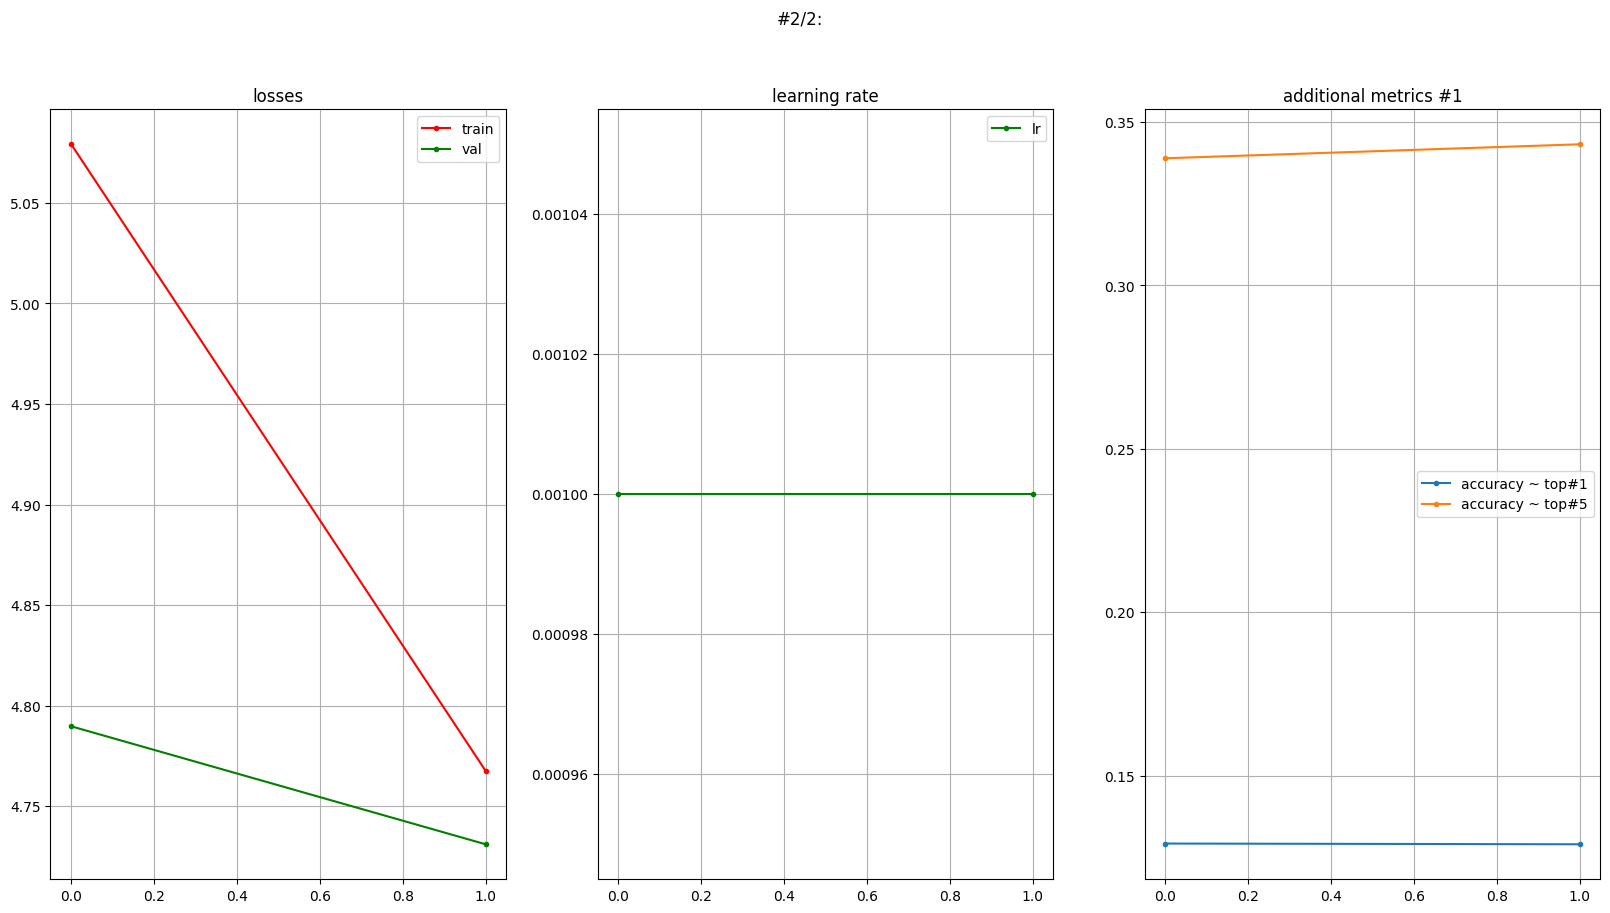

In [27]:
device = get_device()

model, optimizer = create_model_and_optimizer(
    model_class = image_captioning_model,
    model_params = {
        'dropout_p': 0.3,
        'hidden_size_fc': 1024,
        'rnn_hidden': 1024,
        'rnn_layers': 1,
        'gloves': True,
    },
    lr = 1e-3,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = nn.NLLLoss()
ds_train, ds_val = get_train_val_dataset(data_folder="/kaggle/input/image-captioning/data/data", online_image=True, image_prepare_train=None, image_prepare_validation=None)
dataloader_train, dataloader_val = get_loaders(ds_train, ds_val)
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 2,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
)

In [28]:
dfs = get_labels_for_images()

<class 'numpy.ndarray'>
(375, 500, 3)


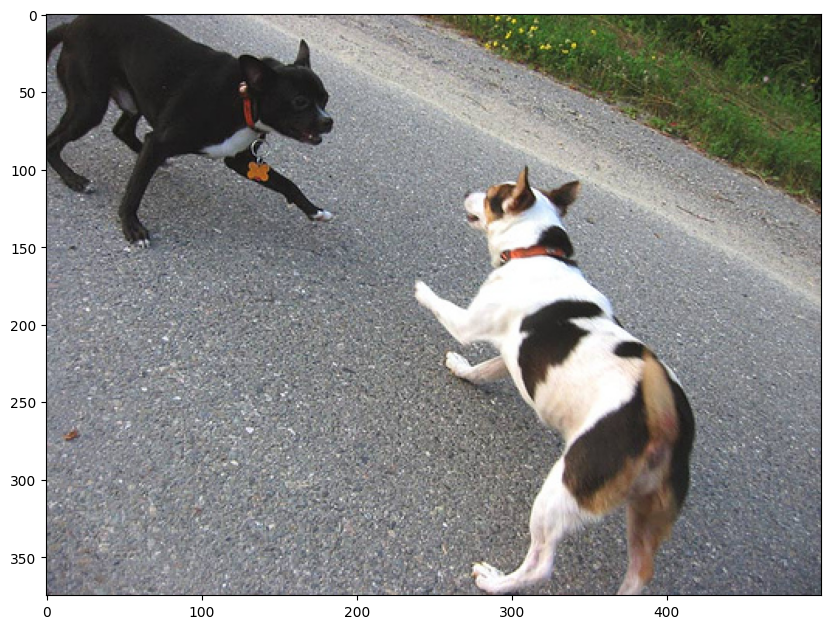

In [29]:
show_image()

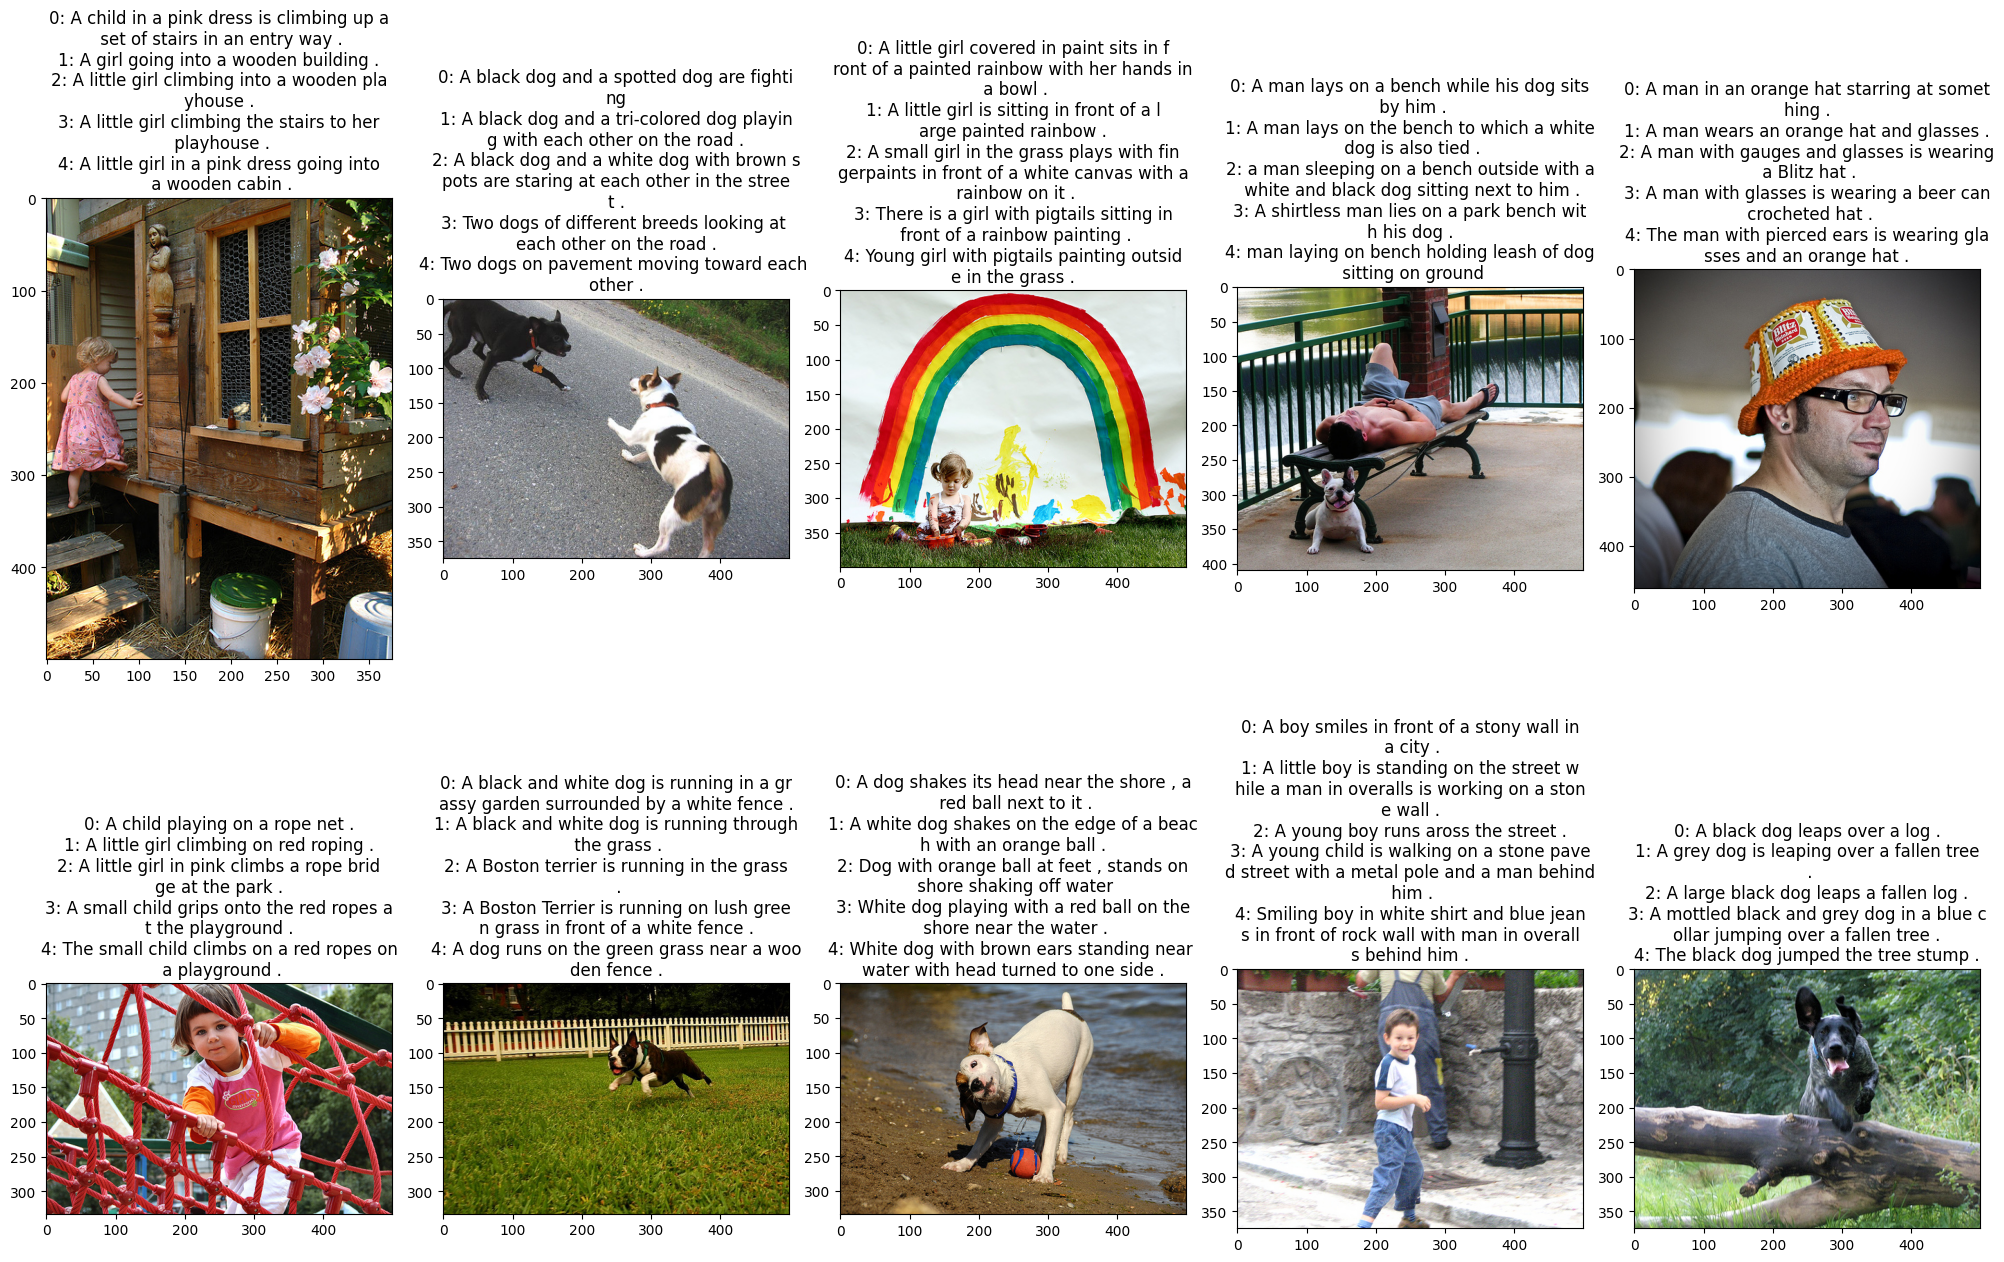

In [30]:
show_labels_with_image(dfs)

In [31]:
channel_mean, channel_std = get_channel_mean_and_std()
#channel_mean, channel_std = get_channel_mean_and_std('/kaggle/input/image-captioning/data/data/train')

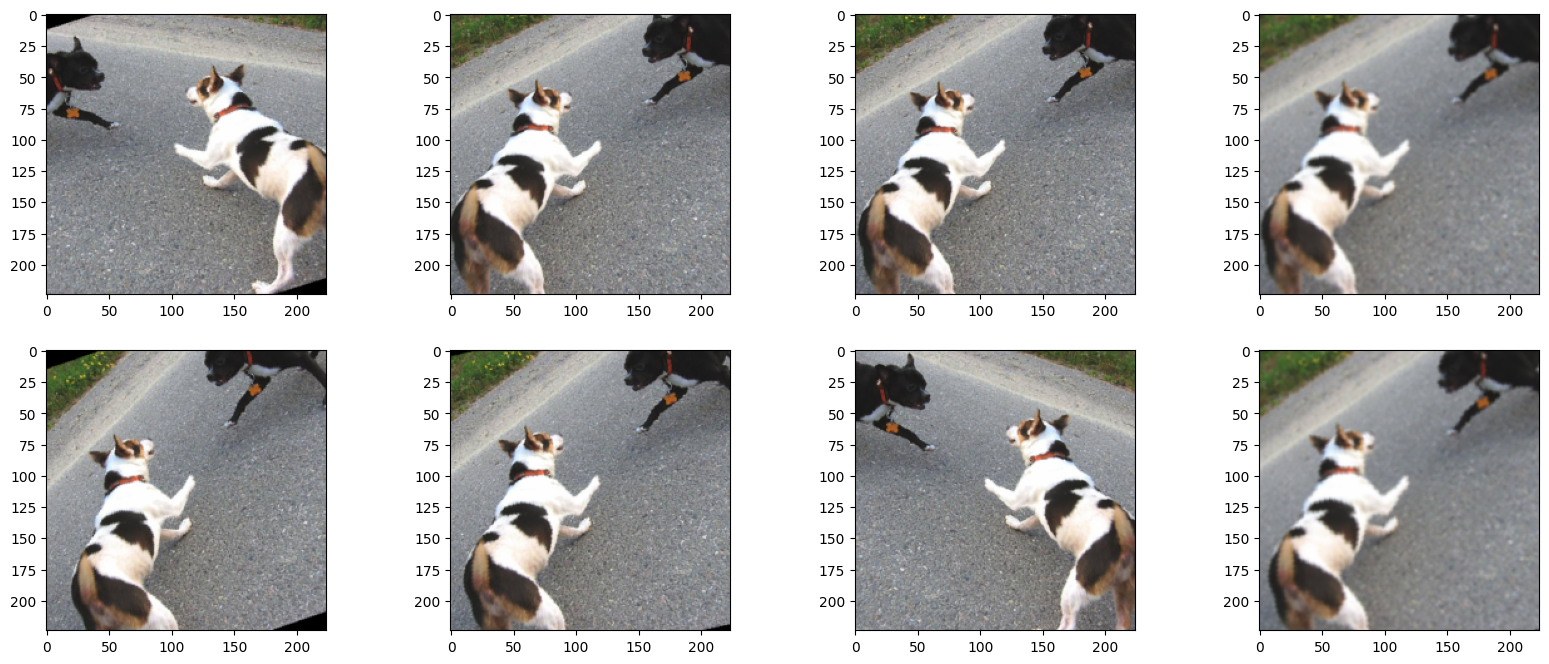

In [32]:
image_prepare_train, _ = get_trasnforms(channel_mean, channel_std)
image = cv2.imread(os.path.join("/kaggle/input/image-captioning/data/data", "train", "0001.png"))
show_tranform_image(image, image_prepare_train, channel_mean, channel_std)

  0%|          | 0/6000 [00:00<?, ?it/s]

39


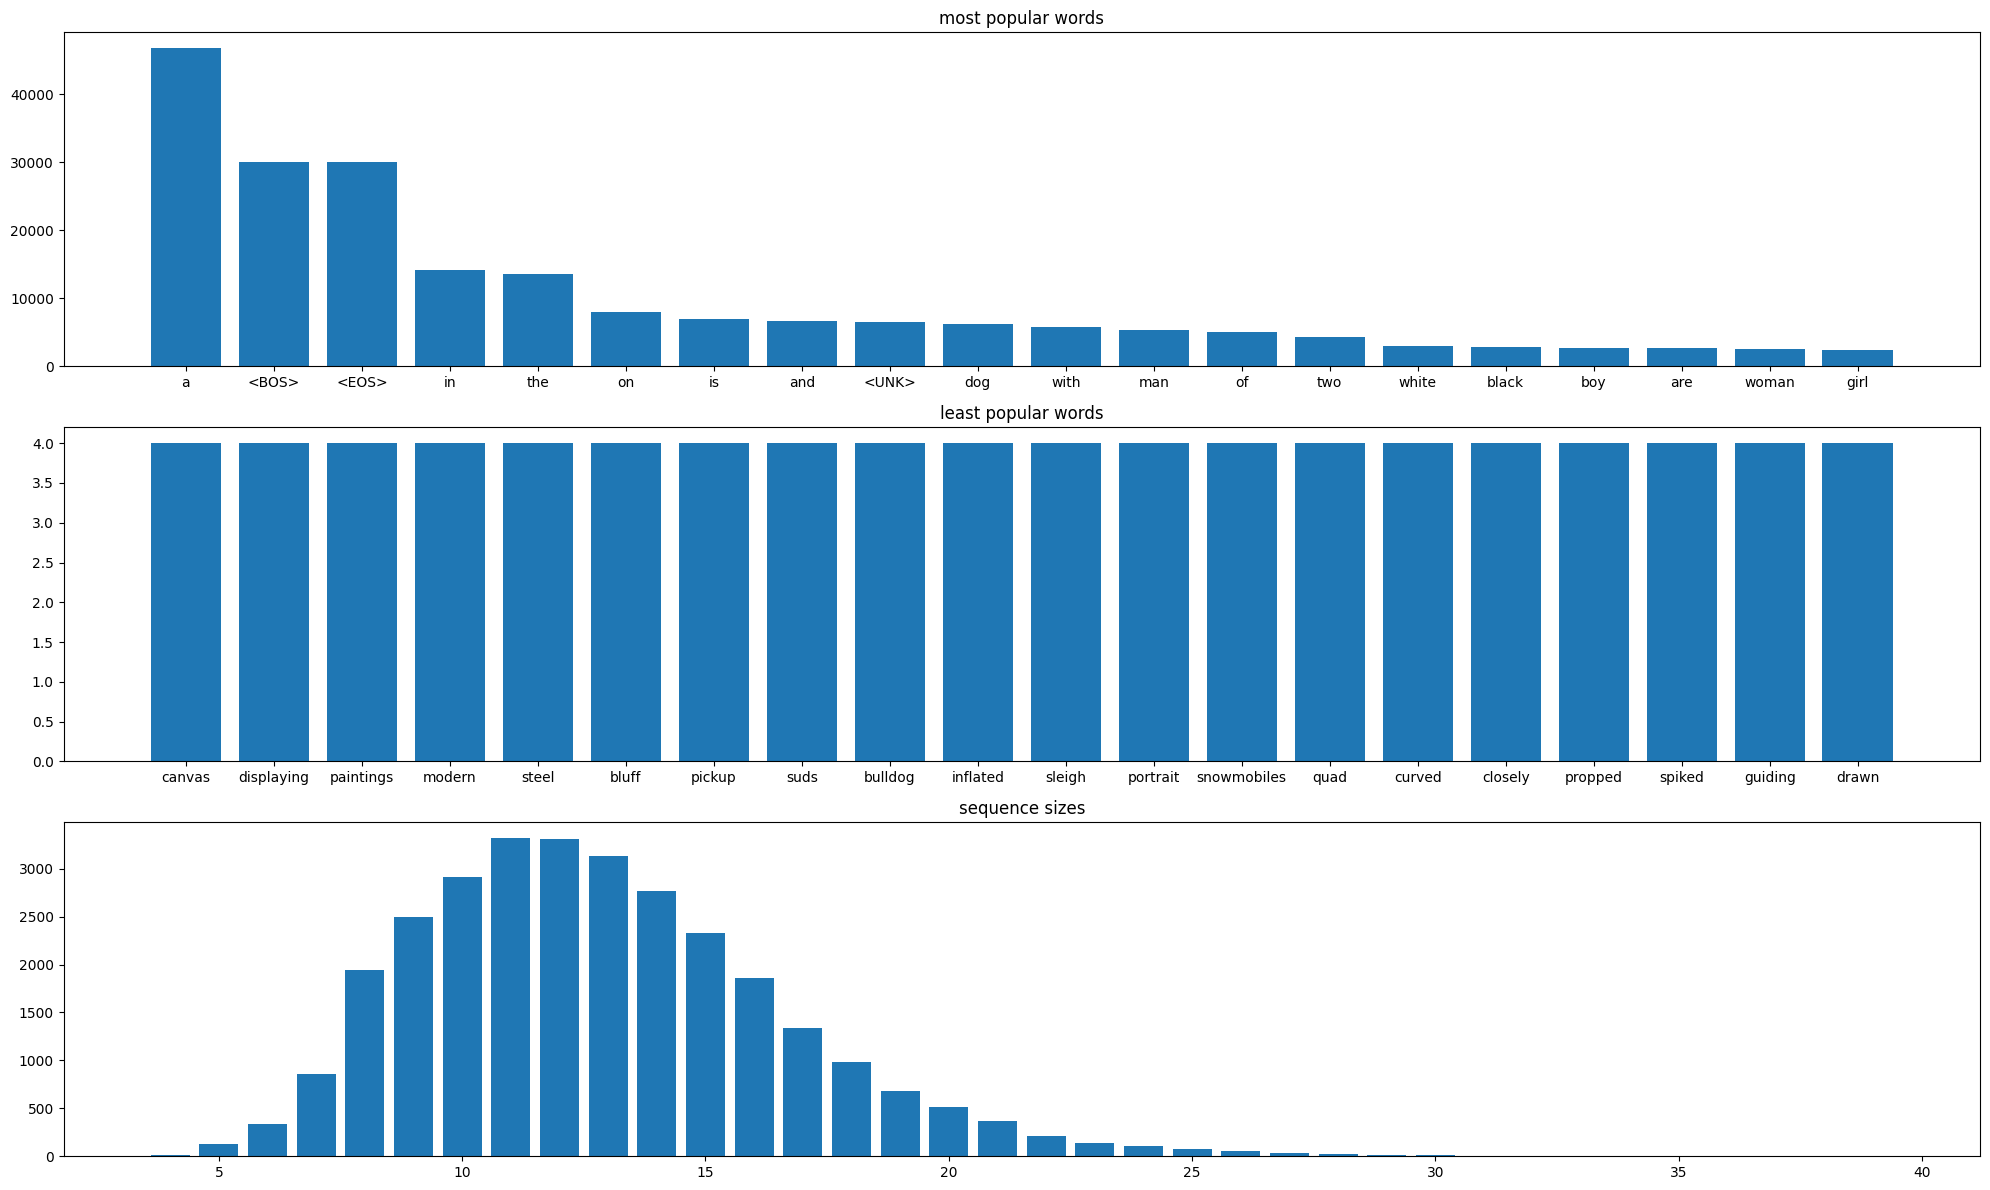

In [33]:
vocab_freq, sizes, max_seq_len = get_tokens_freq_and_max_seq_len(dfs)
print(max_seq_len)
show_tokens_freq(vocab_freq, sizes)

In [34]:
tok_to_ind, ind_to_tok = add_default_tokens(vocab_freq)
text = "Some random text I wrote. And the one, that cann't be forgotten unless I'll decide that... Tho it's still great"
check_tokenizer_operation(text, tok_to_ind, need_print=True)

['<BOS>', 'some', 'random', 'text', 'i', 'wrote', 'and', 'the', 'one', 'that', 'cann', 't', 'be', 'forgotten', 'unless', 'i', 'll', 'decide', 'that', 'tho', 'it', 's', 'still', 'great', '<EOS>']
[1, 336, 0, 382, 29, 24, 139, 633, 605, 1295, 69, 413, 1828, 2632, 2]


In [35]:
ds_train, ds_val = get_train_val_dataset(online_image=True)

/tmp/ipykernel_26/1764753860.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df.iloc[:, 1:] = self.df.iloc[:, 1:].applymap(tokenize)
/tmp/ipykernel_26/1764753860.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df[['sum', 'local_max_seq_len']] = self.df.iloc[:, 1:].applymap(len).agg(['sum', 'max'], axis=1)
/tmp/ipykernel_26/1764753860.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df.iloc[:, 1:] = self.df.iloc[:, 1:].applymap(tokenize)
/tmp/ipykernel_26/1764753860.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df[['sum', 'local_max_seq_len']] = self.df.iloc[:, 1:].applymap(len).agg(['sum', 'max'], axis=1)


In [36]:
check_dataset(ds_train, ds_val)

torch.Size([3, 224, 224])
torch.Size([58, 19])
torch.Size([58])


In [37]:
dataloader_train, dataloader_val = get_loaders(ds_train, ds_val)

In [38]:
check_dataloaders(dataloader_train, batch_size_train=32)